# Synthetic data generation time

This tutorial demonstrates the speed of synthetic data generation.

Before generating synthetic data, we need to

- fit non-negative ALS to real data containing user interactions,
- obtain vector representations of real users,
- fit CopulaGAN to non-negative ALS embeddings of real users. 

We measure the generation time of synthetic users with CopulaGAN for samples in the range of 100K to 10M.

The speed of synthetic data generation using SDVDataGenerator is linearly dependent on the number of created users.  The generation time for 2 million synthetic users is 500 seconds, and for 10 million synthetic users is 2000 seconds for a dense user feature vector of length 64.

In [2]:
import os
import sys
os.environ["JAVA_HOME"] = "/home/jovyan/ivanova/env39_sim4rec_check"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [3]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rs_datasets import MovieLens
import seaborn as sns
import warnings

from pyspark import SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from sim4rec.modules import SDVDataGenerator
from sim4rec.utils import pandas_to_spark

warnings.filterwarnings("ignore") 

In [4]:
SPARK_LOCAL_DIR = "./tmp/task_5"

In [5]:
%%bash -s "$SPARK_LOCAL_DIR"
rm -rf $1

In [6]:
NUM_JOBS = 16

spark = SparkSession.builder\
    .appName("simulator")\
    .master(f"local[{NUM_JOBS}]")\
    .config("spark.sql.shuffle.partitions", f"{3 * NUM_JOBS}")\
    .config("spark.default.parallelism", f"{3 * NUM_JOBS}")\
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.memory", "4g")\
    .config("spark.local.dir", SPARK_LOCAL_DIR)\
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/13 17:09:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/13 17:09:30 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/03/13 17:09:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/13 17:09:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/03/13 17:09:31 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/03/13 17:09:31 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/03/13 17:09:31 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [7]:
SEED = 1234
np.random.seed(SEED)

## Download Data

In [7]:
data = MovieLens("20m")
ratings_df = data.ratings
ratings_df.head()

,user_id,item_id,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
rating_threshold = ratings_df["rating"].median()
rating_threshold

3.5

In [9]:
ratings_df["relevance"] = (ratings_df["rating"] >= rating_threshold).astype(int)

## Data Preprocessing

We encode the user and item IDs with consecutive values so that the new IDs do not contain missing values.

In [10]:
ratings_df["user_idx"] = ratings_df["user_id"].astype("category").cat.codes
ratings_df["item_idx"] = ratings_df["item_id"].astype("category").cat.codes

In [11]:
train = pandas_to_spark(ratings_df)

## Non-negative ALS for User Embeddings

Fit non-negative ALS to historical data to produce the real user vectors that represent their profiles.

In [12]:
# initialization of non-negative ALS
als = ALS(
    rank=64,
    maxIter=5,
    userCol="user_idx",
    itemCol="item_idx",
    ratingCol="relevance",
    seed=SEED,
    nonnegative=True,
)
# fit ALS
als_model = als.fit(train)

Obtain vector representations of real users.

In [13]:
user_features = als_model.userFactors.orderBy("id")
user_features = (user_features.withColumn("user_feature", col("features"))).select(
    ["id"] + [col("user_feature")[i] for i in range(64)]
)
user_features.limit(5).toPandas()

,id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8],...,user_feature[54],user_feature[55],user_feature[56],user_feature[57],user_feature[58],user_feature[59],user_feature[60],user_feature[61],user_feature[62],user_feature[63]
0,0,0.098465,0.052241,0.125119,0.202401,0.178767,0.148965,0.118857,0.080273,0.152939,...,0.077556,0.187669,0.081136,0.129824,0.078120,0.145179,0.096780,0.099917,0.154622,0.113657
1,1,0.083297,0.047674,0.103928,0.181666,0.161923,0.128280,0.096112,0.068772,0.143337,...,0.059835,0.174903,0.070022,0.122740,0.070366,0.123795,0.083381,0.087477,0.137442,0.099442
2,2,0.089750,0.044578,0.118326,0.188298,0.157684,0.135538,0.109513,0.071072,0.142481,...,0.074062,0.166076,0.075291,0.117528,0.068250,0.135233,0.085594,0.092989,0.142653,0.100441
3,3,0.065662,0.048028,0.068513,0.146848,0.143943,0.101966,0.062271,0.059757,0.128780,...,0.031322,0.164175,0.050798,0.111714,0.065364,0.094431,0.072750,0.065016,0.117407,0.087755
4,4,0.076065,0.054559,0.085825,0.180649,0.170346,0.122832,0.076311,0.067553,0.156395,...,0.041212,0.192011,0.060475,0.133150,0.074588,0.115542,0.083266,0.077581,0.139359,0.101348


## CopulaGAN User Embeddings Generator

Fit the SDVDataGenerator with the CopulaGAN synthetic data model to non-negative ALS embeddings of real users.

In [ ]:
# initialization of data generator
sdv_data_generator = SDVDataGenerator(
    label="synth",
    id_column_name="user_id",
    model_name="copulagan",
    parallelization_level=3 * NUM_JOBS,
    device_name="cuda:0",
    seed=SEED,
)
# fit data generator
sdv_data_generator.fit(user_features.drop("id"))

We measure the generation time of synthetic users with CopulaGAN for samples in the range of 100K to 10M.

In [ ]:
num_samples = np.linspace(100000, 10000000, 21)
gen_time_list = []
_ = sdv_data_generator.generate(100).cache().count()
for num in num_samples:
    gen_time = {}
    start = time.time()
    synthetic_users = sdv_data_generator.generate(num).cache()
    synthetic_users.count()
    
    gen_time['n_samples'] = num
    gen_time['time, s'] = time.time() - start
    
    synthetic_users.unpersist()
    gen_time_list.append(gen_time)
    pd.DataFrame(gen_time_list).to_csv('synthetic_gen_time.csv', index=False)

In [14]:
gen_time_df = pd.read_csv('synthetic_gen_time.csv')

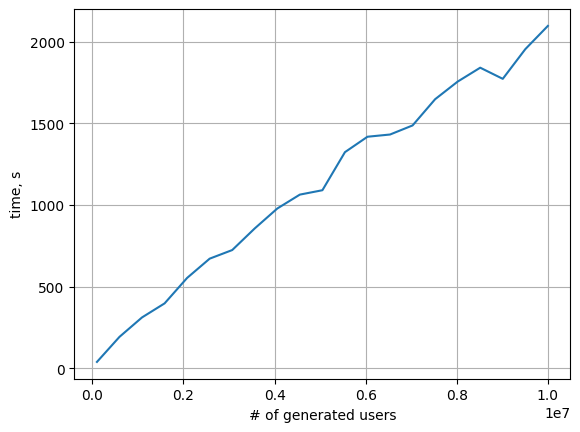

In [15]:
sns.lineplot(gen_time_df, x='n_samples', y='time, s');
plt.grid()
plt.xlabel("# of generated users")
plt.ylabel("time, s");

The speed of synthetic data generation using SDVDataGenerator is linearly dependent on the number of created users.